<a href="https://colab.research.google.com/github/soaresbru/bootcamp-Unimed-Data-science/blob/main/EDA_e_previs%C3%A3o_de_Covid_no_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Análise e Previsão de COVID-19 no Brasil

Neste notebook serão realizadas as principais etapas para realizar as análises dos dados disponíveis e fazer uma breve previsão dos casos e mortes de COVID para o próximo mês no Brasil.

Os dados podem ser encontrados no Kaggle https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset

## Conteúdo
1. Leitura das bases consumidas
2. Análise dos dados
3. Prevendo o número de casos no próximo mês com ARIMA
4. Prevendo o número de casos no próximo mês com Prophet
5. Prevendo o número de mortes no próximo mês com ARIMA
6. Prevendo o número de mortes no próximo mês com Prophet

## 1. Leitura das Bases

Nesta etapa, a base de dados para análise serão carregados



In [118]:
# Importando as bibliotecas padrões
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Biblioteca padrão para trabalhar com datas
from datetime import datetime

# Importando a biblioteca para carregar arquivos do drive
from google.colab import drive

# Importando bibliotecas para fazer  gráficos
import plotly.express as px
import plotly.graph_objects as go

# Instalando e importando biblioteca para previsão temporal
!pip install pmdarima
from pmdarima.arima import auto_arima

#Importnado biblioteca para calculcar o erro MAPE
from sklearn.metrics import mean_absolute_percentage_error

# Decomposição de série temporal
from statsmodels.tsa.seasonal import seasonal_decompose

# importando o Prophet para previsão
from prophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
# Montando o Google Drive
drive.mount('/content/drive')

# Caminho para pegar os arquivos do drive
caminho = '/content/drive/MyDrive/Dataset - projetos dados/covid_19_data.csv' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
# Lendo o arquivo de dados, já importando as colunas "ObservationDate" e "Last Update" em formato de data
df_covid= pd.read_csv(caminho, parse_dates=['ObservationDate', 'Last Update'])

# Olhando as primeriras linhas
df_covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


In [121]:
# olhando algumas informações como o tipo de cada coluna e dados nulos
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   SNo              306429 non-null  int64         
 1   ObservationDate  306429 non-null  datetime64[ns]
 2   Province/State   228329 non-null  object        
 3   Country/Region   306429 non-null  object        
 4   Last Update      306429 non-null  datetime64[ns]
 5   Confirmed        306429 non-null  float64       
 6   Deaths           306429 non-null  float64       
 7   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 18.7+ MB


## 2. Análise dos dados

Nesta etapa o objetivo é conhecer melhor os nossos dados para facilitar no entendimento do problema e na tomada de decisão

In [122]:
# Queremos apenas os dados do Brasil
df_covid_brasil = df_covid[df_covid['Country/Region']=='Brazil']

#Olhando as primeiras linhas
df_covid_brasil.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
84,85,2020-01-23,NaN,Brazil,2020-01-23 17:00:00,0.0,0.0,0.0
2525,2526,2020-02-26,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2631,2632,2020-02-27,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2742,2743,2020-02-28,NaN,Brazil,2020-02-26 23:53:02,1.0,0.0,0.0
2852,2853,2020-02-29,NaN,Brazil,2020-02-29 21:03:05,2.0,0.0,0.0


In [123]:
# olhando algumas informações como o tipo de cada coluna e dados nulos
df_covid_brasil.info()
# Vemos que temos alguns dados faltantes no estado

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10229 entries, 84 to 306342
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SNo              10229 non-null  int64         
 1   ObservationDate  10229 non-null  datetime64[ns]
 2   Province/State   10144 non-null  object        
 3   Country/Region   10229 non-null  object        
 4   Last Update      10229 non-null  datetime64[ns]
 5   Confirmed        10229 non-null  float64       
 6   Deaths           10229 non-null  float64       
 7   Recovered        10229 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 719.2+ KB


In [124]:
# olhando a quantidade de dados por estado
df_covid_brasil['Province/State'].value_counts().sort_values(ascending=False)

# Vemos que os dados estão bem distribídos entre os estados

Acre                   375
Alagoas                375
Amapa                  375
Amazonas               375
Bahia                  375
Ceara                  375
Distrito Federal       375
Espirito Santo         375
Goias                  375
Maranhao               375
Mato Grosso            375
Mato Grosso do Sul     375
Minas Gerais           375
Para                   375
Paraiba                375
Parana                 375
Pernambuco             375
Piaui                  375
Rio Grande do Norte    375
Rio Grande do Sul      375
Rio de Janeiro         375
Rondonia               375
Roraima                375
Santa Catarina         375
Sao Paulo              375
Sergipe                375
Tocantins              375
Unknown                 19
Name: Province/State, dtype: int64

In [125]:
# OLhando para a porcentagem de população de cada estado
"""
Estado              % da pop total  

São Paulo	          21,9%	   
Minas Gerais	      10,1%   
Rio de Janeiro	    8,2%   
Bahia               7,1%   
Paraná	            5,4%   
Rio Grande do Sul	  5,4%   	
Pernambuco	        4,5%   
Ceará	              4,3%  	
Pará 	              4,1%  
Santa Catarina	    3,4%   
Goiás               3,4%   
Maranhão	          3,4%	   
Amazonas	          2,0%   
Espírito Santo	    1,9%	 
Paraíba	            1,9%   
Mato Grosso	        1,7%   
Rio Grande do Norte	1,7%   
Alagoas	            1,6%   
Piauí               1,6%	     
Distrito Federal	  1,4%    
Mato Grosso do Sul	1,3%   
Sergipe	            1,1%   
Rondônia	          0,8%   
Tocantins	          0,7%   
Acre	              0,4%   
Amapá	              0,4%   
Roraima             0,3%  """

'\nEstado              % da pop total  \n\nSão Paulo\t          21,9%\t   \nMinas Gerais\t      10,1%   \nRio de Janeiro\t    8,2%   \nBahia               7,1%   \nParaná\t            5,4%   \nRio Grande do Sul\t  5,4%   \t\nPernambuco\t        4,5%   \nCeará\t              4,3%  \t\nPará \t              4,1%  \nSanta Catarina\t    3,4%   \nGoiás               3,4%   \nMaranhão\t          3,4%\t   \nAmazonas\t          2,0%   \nEspírito Santo\t    1,9%\t \nParaíba\t            1,9%   \nMato Grosso\t        1,7%   \nRio Grande do Norte\t1,7%   \nAlagoas\t            1,6%   \nPiauí               1,6%\t     \nDistrito Federal\t  1,4%    \nMato Grosso do Sul\t1,3%   \nSergipe\t            1,1%   \nRondônia\t          0,8%   \nTocantins\t          0,7%   \nAcre\t              0,4%   \nAmapá\t              0,4%   \nRoraima             0,3%  '

In [126]:
# OLhando os casos por estado em porcentagem
casos_por_estado = df_covid_brasil.groupby(['Province/State'])['Confirmed'].sum().sort_values(ascending=False)

(casos_por_estado / casos_por_estado.sum())*100

Province/State
Sao Paulo              19.677267
Minas Gerais            7.781710
Bahia                   6.292592
Santa Catarina          5.706810
Rio Grande do Sul       5.651953
Parana                  5.518144
Rio de Janeiro          5.491009
Ceara                   4.656896
Para                    3.842455
Goias                   3.815334
Distrito Federal        3.083928
Espirito Santo          3.014765
Pernambuco              2.922144
Amazonas                2.843366
Maranhao                2.529401
Mato Grosso             2.379156
Paraiba                 2.203156
Piaui                   1.756913
Mato Grosso do Sul      1.603017
Rio Grande do Norte     1.550863
Sergipe                 1.485548
Alagoas                 1.405116
Rondonia                1.384574
Tocantins               1.146542
Amapa                   0.868085
Roraima                 0.826934
Acre                    0.562324
Unknown                 0.000000
Name: Confirmed, dtype: float64

In [127]:
# OLhando a quantidade em porcentagem de casos mortes por estado
mortes_por_estado = df_covid_brasil.groupby(['Province/State'])['Deaths'].sum().sort_values(ascending=False)
(mortes_por_estado/mortes_por_estado.sum())*100
# A maior parte das mortes vem de SP, RJ e MG

Province/State
Sao Paulo              23.969900
Rio de Janeiro         12.502505
Minas Gerais            6.592132
Ceara                   5.278705
Rio Grande do Sul       4.728271
Pernambuco              4.686563
Bahia                   4.538343
Parana                  4.306565
Para                    3.906764
Amazonas                3.348202
Goias                   3.315624
Santa Catarina          2.670362
Espirito Santo          2.462798
Mato Grosso             2.255222
Maranhao                2.216567
Distrito Federal        1.972534
Paraiba                 1.803958
Rio Grande do Norte     1.495005
Piaui                   1.353582
Alagoas                 1.246956
Sergipe                 1.214266
Mato Grosso do Sul      1.154250
Rondonia                1.083896
Tocantins               0.609332
Amapa                   0.454678
Acre                    0.416953
Roraima                 0.416067
Unknown                 0.000000
Name: Deaths, dtype: float64

In [128]:
# Chama a atenção que o RJ, Ceara, Amazonas possuem um número elevado de mortes comparada com sua população
# E que SC, ES, DF, Rondonia, Amapa, Roraima possuem um número elevado de casos comparada com sua população

In [129]:
# Agora vamos ver a taxa de morte por estado
((mortes_por_estado/casos_por_estado)*100).sort_values(ascending=False)
# O Rio de Janeiro se destaca com o maior numero de pessoas infectadas que morrem por Covid

Province/State
Rio de Janeiro         6.217090
Pernambuco             4.379204
Sao Paulo              3.326164
Amazonas               3.215298
Ceara                  3.095089
Para                   2.776199
Rio Grande do Norte    2.632155
Mato Grosso            2.588265
Alagoas                2.423156
Maranhao               2.392794
Goias                  2.372876
Minas Gerais           2.313093
Rio Grande do Sul      2.284263
Paraiba                2.235752
Sergipe                2.231872
Espirito Santo         2.230579
Rondonia               2.137539
Parana                 2.130984
Piaui                  2.103665
Acre                   2.024620
Bahia                  1.969292
Mato Grosso do Sul     1.966093
Distrito Federal       1.746476
Tocantins              1.451131
Amapa                  1.430160
Roraima                1.373837
Santa Catarina         1.277671
Unknown                     NaN
dtype: float64

In [130]:
# Agora vamos ver a taxa de recuperação por estado
recupera_por_estado = df_covid_brasil.groupby(['Province/State'])['Recovered'].sum().sort_values(ascending=False)
((recupera_por_estado/casos_por_estado)*100).sort_values(ascending=False)

Province/State
Unknown                      inf
Piaui                  96.974299
Bahia                  94.762066
Goias                  94.349055
Rio Grande do Sul      94.019897
Santa Catarina         93.979357
Alagoas                93.595819
Distrito Federal       93.411568
Para                   92.408607
Espirito Santo         91.404029
Rio de Janeiro         91.199118
Mato Grosso            90.995191
Maranhao               90.669474
Mato Grosso do Sul     90.353714
Minas Gerais           89.701282
Sergipe                87.622613
Rondonia               86.373516
Sao Paulo              85.206228
Tocantins              84.571500
Pernambuco             83.723739
Amazonas               83.649625
Roraima                83.452675
Acre                   82.616716
Ceara                  75.695435
Amapa                  73.654401
Paraiba                70.780458
Parana                 70.427393
Rio Grande do Norte    62.247648
dtype: float64

In [131]:
# Vamos ver os casos ativos por estado
(casos_por_estado - mortes_por_estado - recupera_por_estado).sort_values(ascending=False)
# Observa-se que muitas mortes e recuperações foram registradas como Unknown, por isso está como negativo

Province/State
Sao Paulo              59781663.0
Parana                 40117440.0
Ceara                  26167177.0
Minas Gerais           16463202.0
Paraiba                15749929.0
Rio Grande do Norte    14429817.0
Amazonas                9894544.0
Pernambuco              9210251.0
Santa Catarina          7170912.0
Amapa                   5730086.0
Rio Grande do Sul       5534037.0
Bahia                   5449133.0
Espirito Santo          5084041.0
Para                    4901771.0
Maranhao                4649065.0
Tocantins               4245664.0
Rondonia                4214311.0
Mato Grosso             4044404.0
Sergipe                 3992926.0
Distrito Federal        3955992.0
Rio de Janeiro          3758720.0
Roraima                 3324195.0
Goias                   3313455.0
Mato Grosso do Sul      3261674.0
Acre                    2288074.0
Alagoas                 1481963.0
Piaui                    429169.0
Unknown                -3680510.0
dtype: float64

In [132]:
# Agregando os valores de casos confirmados, recuperados e mortes
df_brasil_casos =df_covid_brasil.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [133]:
# Plotando agora o gráfico de casos confirmados, recuperados e mortes ao longo do tempo
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_brasil_casos.index, y=df_brasil_casos["Confirmed"], name='Confirmados'))
fig.add_trace(go.Scatter(x=df_brasil_casos.index, y=df_brasil_casos['Recovered'], name='Recuperados'))

fig.add_trace(go.Scatter(x=df_brasil_casos.index, y=df_brasil_casos['Deaths'], name='Mortes'))

fig.update_layout(title='Casos de Covid',
                   xaxis_title='data',
                   yaxis_title='Número de casos')
fig.show()

Para calcular a taxa de crescimento médio em intervalos regulares podemos usar a seguinte fórmula

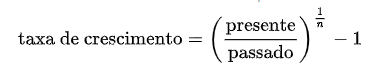

Ou Podemos usar:  
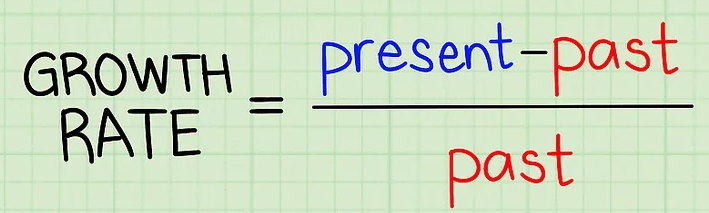

Fonte; https://pt.wikihow.com/Calcular-Taxa-de-Crescimento

In [134]:
# Vamos usar então essa segunda fómermula para calcular a taxa de crescimento
# Vamos plotar o gráfico da taxa de crescimento de casos confirmados
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_brasil_casos.index, y=(df_brasil_casos["Confirmed"]- df_brasil_casos["Confirmed"].shift())/df_brasil_casos["Confirmed"].shift()),
)
fig.update_layout(title='taxa de crescimento de casos confirmados',
                   xaxis_title='data',
                   yaxis_title='taxa de crescimento')
fig.show()

In [135]:
# Assim podemos calcular a taxa de crescimento médio
media_diaria = ((df_brasil_casos["Confirmed"]- df_brasil_casos["Confirmed"].shift())/df_brasil_casos["Confirmed"].shift())

df_filter = media_diaria.isin([np.nan, np.inf, -np.inf]) 
  
media_diaria = media_diaria[~df_filter] 
  
media_diaria.dropna(inplace=True) 

media_diaria.mean() 

0.04414091343479946

In [136]:
# Agora podemos fazer o mesmo e calcular para quem se recuperou
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_brasil_casos.index, y=(df_brasil_casos["Recovered"]- df_brasil_casos["Recovered"].shift())/df_brasil_casos["Recovered"].shift()),
)
fig.update_layout(title='taxa de crescimento de casos recuperados',
                   xaxis_title='data',
                   yaxis_title='taxa de crescimento')
fig.show()

In [137]:
# Calculando a taxa de recuperação média
tx_recupera_diaria = ((df_brasil_casos["Recovered"]- df_brasil_casos["Recovered"].shift())/df_brasil_casos["Recovered"].shift())

df_filter = tx_recupera_diaria.isin([np.nan, np.inf, -np.inf]) 
  
tx_recupera_diaria = tx_recupera_diaria[~df_filter] 
  
tx_recupera_diaria.dropna(inplace=True) 

tx_recupera_diaria.mean() 

0.11360112510249418

In [138]:
# Agora podemos fazer o mesmo e calcular para as mortes
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_brasil_casos.index, y=(df_brasil_casos["Deaths"]- df_brasil_casos["Deaths"].shift())/df_brasil_casos["Deaths"].shift()),
)
fig.update_layout(title='taxa de crescimento de mortes',
                   xaxis_title='data',
                   yaxis_title='taxa de crescimento')
fig.show()

In [139]:
# Calculando a taxa média de mortes
tx_recupera_diaria = ((df_brasil_casos["Deaths"]- df_brasil_casos["Deaths"].shift())/df_brasil_casos["Deaths"].shift())

df_filter = tx_recupera_diaria.isin([np.nan, np.inf, -np.inf]) 
  
tx_recupera_diaria = tx_recupera_diaria[~df_filter] 
  
tx_recupera_diaria.dropna(inplace=True) 

tx_recupera_diaria.mean() 

0.03488328605490433

## 3. Prevendo o número de casos no próximo mês com ARIMA

Nesta etapa o objetivo é fazer a previsão para o próximo mês

In [140]:
# Dividir em treino e teste
treino = df_brasil_casos['2020-02-26': "2021-04-30"]
teste = df_brasil_casos["2021-05-01":]

In [141]:
# Selecionando apenas a coluna Confirmados para fazermos a previsão de casos confirmados
treino_previsao= treino['Confirmed']
teste_previsao = teste['Confirmed']
previsao_teste_treino = pd.concat([treino_previsao,teste_previsao],axis=0)

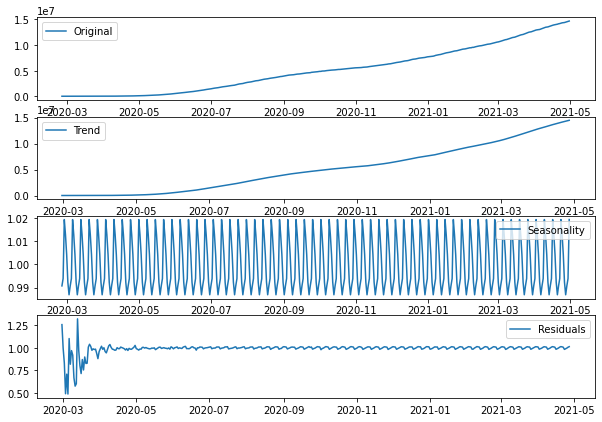

In [142]:
#  Vamos vera tendência a sazonalidade e o resíduo dos dados de treino de casos confirmados

decomposition = seasonal_decompose(treino_previsao, model='multiplicative')  
# teste tambem com model='additive' e veja se você nota alguma diferença

# Fazendo esse teste a grande diferença ficou na parte residual

# define os componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plots
plt.subplots(figsize=(10, 7))
plt.subplot(411)
plt.plot(treino_previsao, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

In [143]:
# Aplicando o auto_arima para sabermos os melhores parâmetros
model = auto_arima(treino_previsao,
                   method= 'nm',
                   max_D=2,
                   stepwise=True,
                   maxiter =50,
                   trace=True
                   )

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=9585.647, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9578.166, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=9544.554, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=9449.348, Time=0.52 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=9423.659, Time=0.42 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=9560.325, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=9549.123, Time=0.31 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=9516.265, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=9536.861, Time=0.30 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9422.871, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9448.750, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9546.490, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9583.285, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=9551.827, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept

In [144]:
# Aplicando os melhores parametros ao modelo
model.fit(treino_previsao)

ARIMA(method='nm', order=(1, 2, 1), scoring_args={}, suppress_warnings=True)

In [145]:
# Fazendo a previsão para os próximos 29 dias que é o dados do mês de maio que temos
previsao=model.predict(n_periods=29)

In [146]:
# Tranformando a previsão em Dataframe
previsao=pd.DataFrame(previsao,index=teste.index, columns=['previsão'])
previsao

,previsão
ObservationDate,
2021-05-01,1.472535e+07
2021-05-02,1.479124e+07
2021-05-03,1.485711e+07
2021-05-04,1.492306e+07
2021-05-05,1.498914e+07
2021-05-06,1.505535e+07
2021-05-07,1.512169e+07
2021-05-08,1.518817e+07
2021-05-09,1.525478e+07


<Figure size 1440x360 with 0 Axes>

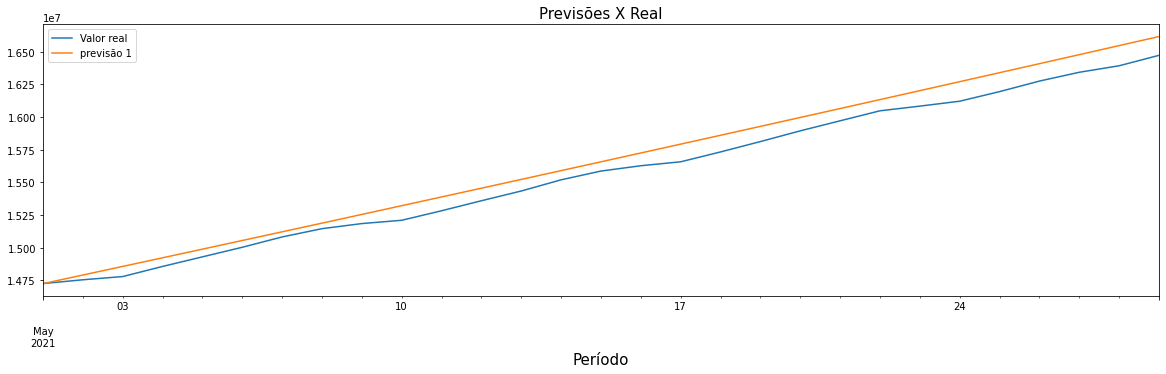

In [147]:
# Vamos vermos no gráfico se o valor encotrado é parecido com o valor real
plt.figure(figsize=(20,5))
pd.concat([teste_previsao,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1']);

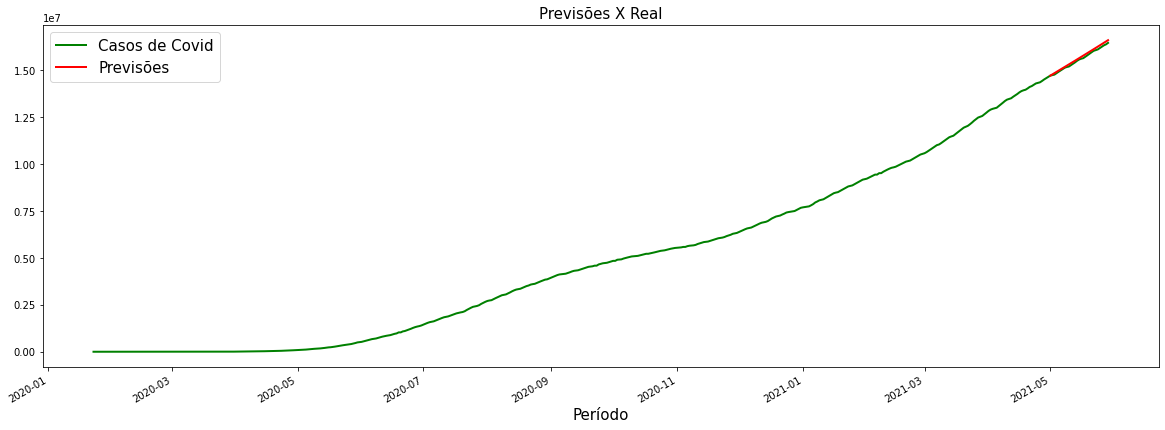

In [148]:
# Olhando para a mesma coisa, mas observando toda a janela de tempo
pd.concat([df_brasil_casos['Confirmed'],previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Casos de Covid','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();

In [149]:
# Vendo o valor do erro, no caso foi escolhido o MAPE

mean_absolute_percentage_error(teste_previsao, previsao)

0.005967400263522233

In [150]:
# Agora que testamos o modelo e o erro consideramos aceitável podemos aplicar para os dados futuros
model.fit(previsao_teste_treino)

previsao2=model.predict(n_periods=33)
previsao2=pd.DataFrame(previsao2, 
                      index=pd.date_range(start='2021-06-01',end='2021-07-01', freq='D'),
                      columns=['nova previsão'])
previsao2

,nova previsão
2021-06-01,1.667749e+07
2021-06-02,1.674485e+07
2021-06-03,1.681230e+07
2021-06-04,1.687990e+07
2021-06-05,1.694765e+07
2021-06-06,1.701556e+07
2021-06-07,1.708363e+07
2021-06-08,1.715186e+07
2021-06-09,1.722025e+07
2021-06-10,1.728880e+07


<Figure size 1440x360 with 0 Axes>

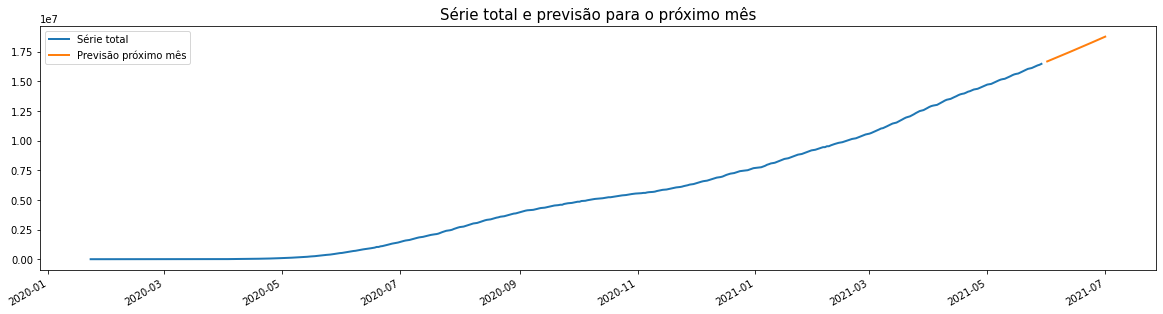

In [151]:
# PLotando o gráfico para vermos a previsão
plt.figure(figsize=(20,5))
pd.concat([df_brasil_casos['Confirmed'],previsao2],axis=1).plot(figsize=(20,5), linewidth=2)
plt.xlabel('')
plt.title('Série total e previsão para o próximo mês',size=15)
plt.legend(['Série total','Previsão próximo mês'])
plt.show();

## 4. Prevendo o número de casos no próximo mês com Prophet

Nesta etapa o objetivo é fazer a previsão para o próximo mês

In [152]:
# Devemos renomear as colunas pois o algoritmo do Prophet entende se estiver a coluna data nomeada como 'ds', e o valor que se deseja prever como "y"
treino_prophet =treino_previsao.reset_index()
treino_prophet = treino_prophet.rename(columns={'ObservationDate' : 'ds', 'Confirmed': 'y'})

teste_prophet = teste_previsao.reset_index()
teste_prophet = teste_prophet.rename(columns={'ObservationDate' : 'ds', 'Confirmed': 'y'})

prophet_teste_treino = pd.concat([treino_prophet,teste_prophet],axis=0)

In [153]:
# Criando o modelo
modelo = Prophet()

# Ajustando o modelo aos dados
modelo.fit(treino_prophet)

# Criando dataframe com os períodos futuros para as previsões, vamos fazer a previsão para os próximos 30 dias
futuro = modelo.make_future_dataframe(periods= 30, freq = '1d')

# Realizando as previsões
previsao= modelo.predict(futuro)

# Agora podemos ver a nossa previsão
previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/mbgx582f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/x1srdcxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39259', 'data', 'file=/tmp/tmp6sty67d3/mbgx582f.json', 'init=/tmp/tmp6sty67d3/x1srdcxc.json', 'output', 'file=/tmp/tmp6sty67d3/prophet_model8ka7glhs/prophet_model-20221024142108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:21:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-26,-9013.210185,-74628.962583,62810.283522,-9013.210185,-9013.210185,-1850.968278,-1850.968278,-1850.968278,-1850.968278,-1850.968278,-1850.968278,0.0,0.0,0.0,-10864.178464
1,2020-02-27,-8462.198806,-73594.153273,67590.522494,-8462.198806,-8462.198806,6038.490799,6038.490799,6038.490799,6038.490799,6038.490799,6038.490799,0.0,0.0,0.0,-2423.708007
2,2020-02-28,-7911.187426,-66150.290782,74002.031873,-7911.187426,-7911.187426,11285.413253,11285.413253,11285.413253,11285.413253,11285.413253,11285.413253,0.0,0.0,0.0,3374.225827
3,2020-02-29,-7360.176046,-63736.897304,73615.606421,-7360.176046,-7360.176046,11675.014267,11675.014267,11675.014267,11675.014267,11675.014267,11675.014267,0.0,0.0,0.0,4314.838220
4,2020-03-01,-6809.164667,-74793.570187,61387.698117,-6809.164667,-6809.164667,-470.380642,-470.380642,-470.380642,-470.380642,-470.380642,-470.380642,0.0,0.0,0.0,-7279.545309


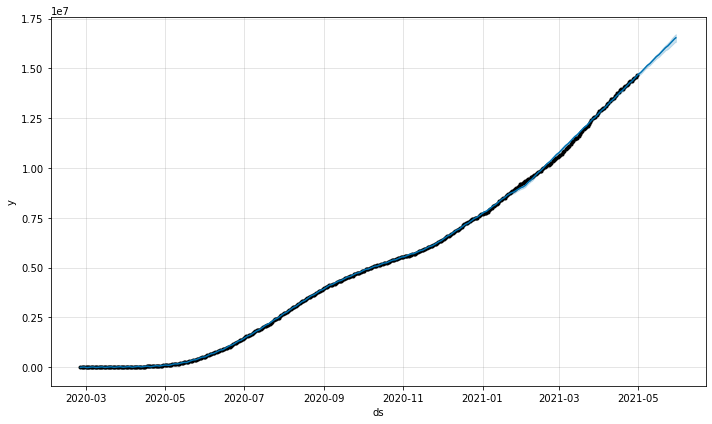

In [154]:
# plotando o gráfico de previsão
modelo.plot(previsao)

data_previsao =previsao[['ds', 'yhat']]
df_previsao = data_previsao.merge(teste_prophet, how='inner', on='ds')

In [155]:
# Calculando o erro MAPE

y_true = df_previsao['y']
y_pred = df_previsao['yhat']
mean_absolute_percentage_error(y_true, y_pred)

0.0008363974356726378

Para este caso, o resultado encontrado com o Prophet foi melhor do que o encontrado com ARIMA

In [156]:
# Recriando o modelo
modelo = Prophet()

# Ajustando o modelo aos dados
modelo.fit(prophet_teste_treino)

# Criando dataframe com os períodos futuros para as previsões, vamos fazer a previsão para os próximos 30 dias
futuro = modelo.make_future_dataframe(periods= 30, freq = '1d')

# Realizando as previsões
previsao= modelo.predict(futuro)

# Agora podemos ver a nossa previsão
previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/n_cpv6tx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/9ovnvijl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76171', 'data', 'file=/tmp/tmp6sty67d3/n_cpv6tx.json', 'init=/tmp/tmp6sty67d3/9ovnvijl.json', 'output', 'file=/tmp/tmp6sty67d3/prophet_model30n_23bu/prophet_model-20221024142111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:21:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-26,-4406.696563,-49686.502735,35831.332279,-4406.696563,-4406.696563,-2384.479298,-2384.479298,-2384.479298,-2384.479298,-2384.479298,-2384.479298,0.0,0.0,0.0,-6791.175861
1,2020-02-27,-4133.363668,-42048.976475,46107.864752,-4133.363668,-4133.363668,5421.037457,5421.037457,5421.037457,5421.037457,5421.037457,5421.037457,0.0,0.0,0.0,1287.673789
2,2020-02-28,-3860.030772,-37588.327271,53863.724310,-3860.030772,-3860.030772,11149.995483,11149.995483,11149.995483,11149.995483,11149.995483,11149.995483,0.0,0.0,0.0,7289.964711
3,2020-02-29,-3586.697877,-31981.262216,53663.042241,-3586.697877,-3586.697877,12660.050166,12660.050166,12660.050166,12660.050166,12660.050166,12660.050166,0.0,0.0,0.0,9073.352289
4,2020-03-01,-3313.364982,-47182.577018,43177.555122,-3313.364982,-3313.364982,604.744305,604.744305,604.744305,604.744305,604.744305,604.744305,0.0,0.0,0.0,-2708.620677


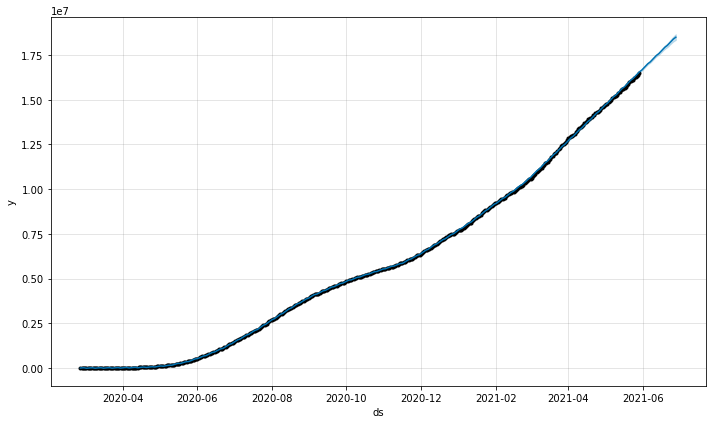

In [157]:
# plotando o gráfico de previsão
modelo.plot(previsao)

data_previsao =previsao[['ds', 'yhat']]
df_previsao = data_previsao.merge(teste_prophet, how='inner', on='ds')

In [158]:
data_previsao.tail(31)

,ds,yhat
458,2021-05-29,1.655116e+07
459,2021-05-30,1.660498e+07
460,2021-05-31,1.665391e+07
461,2021-06-01,1.672500e+07
462,2021-06-02,1.679960e+07
463,2021-06-03,1.687327e+07
464,2021-06-04,1.694487e+07
465,2021-06-05,1.701225e+07
466,2021-06-06,1.706606e+07
467,2021-06-07,1.711499e+07


## 5. Prevendo o número de mortes no próximo mês com ARIMA

Nesta etapa o objetivo é fazer a previsão para o próximo mês

In [159]:
# Selecionando apenas a coluna Confirmados para fazermos a previsão de casos confirmados
treino_previsao= treino['Deaths']
teste_previsao = teste['Deaths']
previsao_teste_treino = pd.concat([treino_previsao,teste_previsao],axis=0)

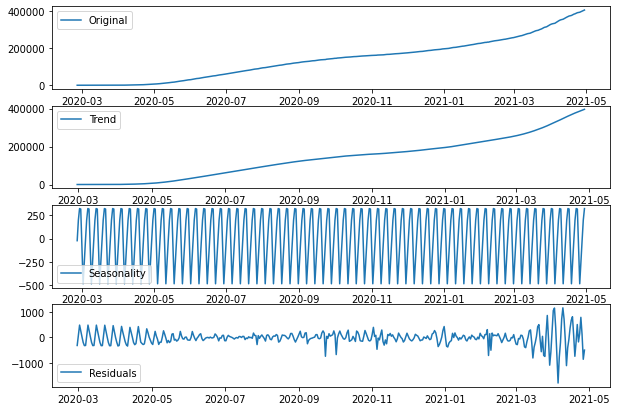

In [160]:
#  Vamos vera tendência a sazonalidade e o resíduo dos dados de treino de casos confirmados

decomposition = seasonal_decompose(treino_previsao, model='additive')  

# define os componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plots
plt.subplots(figsize=(10, 7))
plt.subplot(411)
plt.plot(treino_previsao, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

In [161]:
# Observa-se um residuo muito grande no final da série temporal, provavelmente vai prejudir um pouco a previsão do modelo

In [162]:
# Aplicando o auto_arima para sabermos os melhores parâmetros
model = auto_arima(treino_previsao,
                   method= 'nm',
                   max_D=2,
                   stepwise=True,
                   maxiter =50,
                   trace=True
                   )

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=6524.540, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6516.918, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=6506.237, Time=0.22 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=6429.023, Time=0.45 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=6508.221, Time=0.45 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=6460.284, Time=0.54 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=6510.122, Time=0.53 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6426.894, Time=0.74 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6518.852, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=6510.553, Time=0.57 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6521.644, Time=0.65 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6508.140, Time=0.36 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=6513.624, Time=0.82 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 6.388 seconds


In [163]:
# Aplicando os melhores parametros ao modelo
model.fit(treino_previsao)

ARIMA(method='nm', order=(0, 2, 1), scoring_args={}, suppress_warnings=True)

In [164]:
# Fazendo a previsão para os próximos 29 dias que é o dados do mês de maio que temos
previsao=model.predict(n_periods=29)

In [165]:
# Tranformando a previsão em Dataframe
previsao=pd.DataFrame(previsao,index=teste.index, columns=['previsão'])
previsao

,previsão
ObservationDate,
2021-05-01,406456.420941
2021-05-02,409138.188532
2021-05-03,411826.302771
2021-05-04,414520.763659
2021-05-05,417221.571196
2021-05-06,419928.725382
2021-05-07,422642.226216
2021-05-08,425362.073700
2021-05-09,428088.267832


<Figure size 1440x360 with 0 Axes>

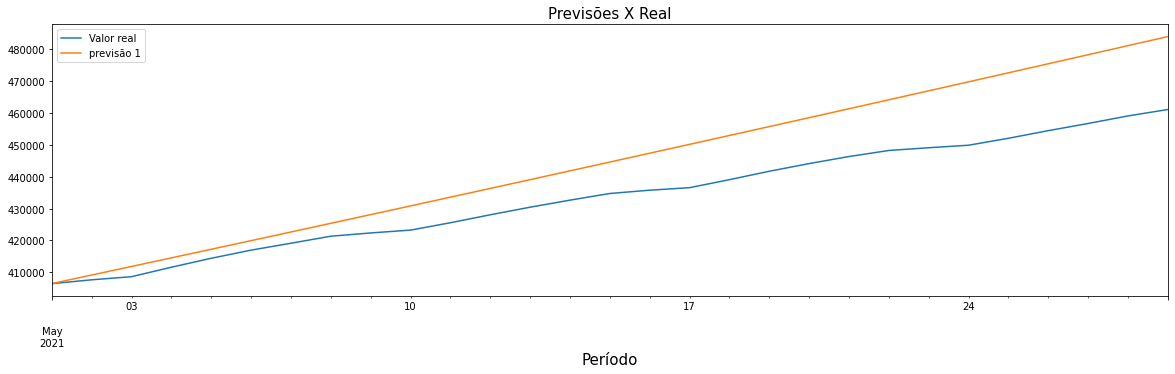

In [166]:
# Vamos vermos no gráfico se o valor encontrado é parecido com o valor real
plt.figure(figsize=(20,5))
pd.concat([teste_previsao,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1']);

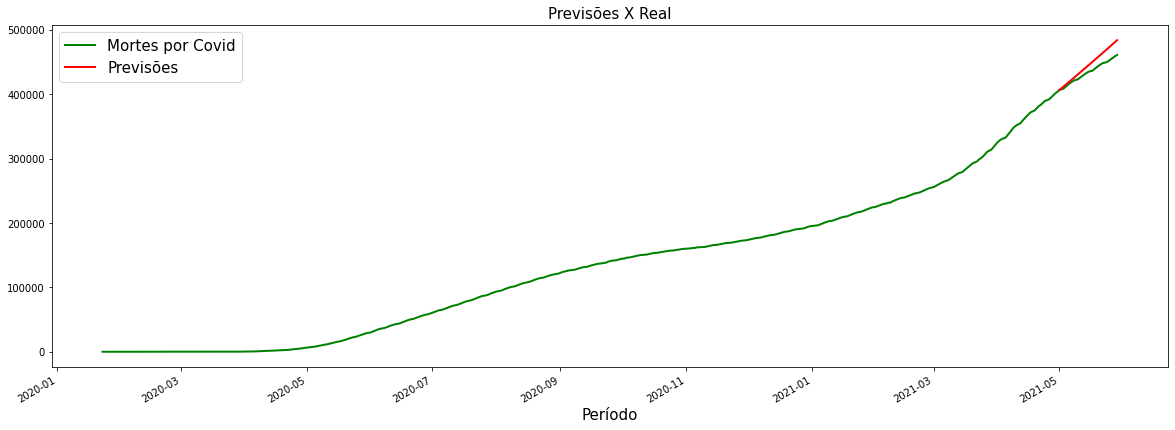

In [167]:
# Olhando para a mesma coisa, mas observando toda a janela de tempo
pd.concat([df_brasil_casos['Deaths'],previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Mortes por Covid','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();

In [168]:
# Vendo o valor do erro, no caso foi escolhido o MAPE

mean_absolute_percentage_error(teste_previsao, previsao)

0.02508132102211366

In [169]:
# Vemos que o modelo não captou muito bem a previsão, mesmo assim vamos continuar a análise
model.fit(previsao_teste_treino)

previsao2=model.predict(n_periods=33)
previsao2=pd.DataFrame(previsao2, 
                      index=pd.date_range(start='2021-06-01',end='2021-07-01', freq='D'),
                      columns=['nova previsão'])
previsao2

,nova previsão
2021-06-01,467188.567273
2021-06-02,469243.606763
2021-06-03,471304.238121
2021-06-04,473370.461345
2021-06-05,475442.276435
2021-06-06,477519.683393
2021-06-07,479602.682216
2021-06-08,481691.272907
2021-06-09,483785.455464
2021-06-10,485885.229888


<Figure size 1440x360 with 0 Axes>

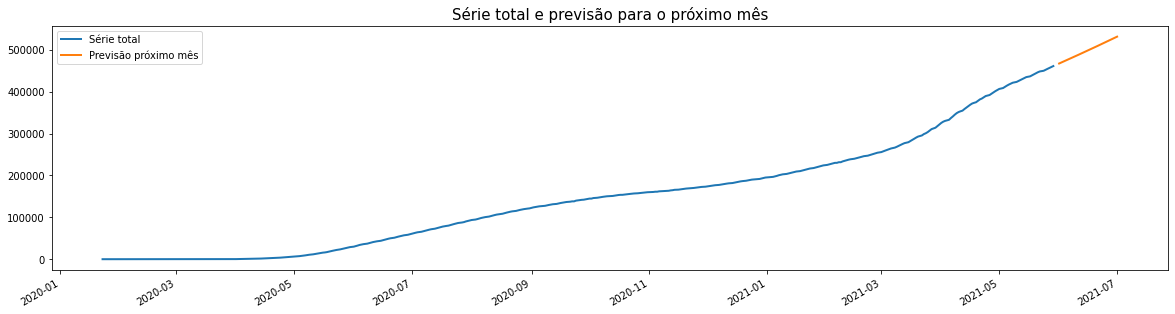

In [170]:
# PLotando o gráfico para vermos a previsão
plt.figure(figsize=(20,5))
pd.concat([df_brasil_casos['Deaths'],previsao2],axis=1).plot(figsize=(20,5), linewidth=2)
plt.xlabel('')
plt.title('Série total e previsão para o próximo mês',size=15)
plt.legend(['Série total','Previsão próximo mês'])
plt.show();

## 6. Prevendo o número de mortes no próximo mês com Prophet

Nesta etapa o objetivo é fazer a previsão para o próximo mês

In [171]:
# Devemos renomear as colunas pois o algoritmo do Prophet entende se estiver a coluna data nomeada como 'ds', e o valor que se deseja prever como "y"
treino_prophet =treino_previsao.reset_index()
treino_prophet = treino_prophet.rename(columns={'ObservationDate' : 'ds', 'Deaths': 'y'})

teste_prophet = teste_previsao.reset_index()
teste_prophet = teste_prophet.rename(columns={'ObservationDate' : 'ds', 'Deaths': 'y'})

prophet_teste_treino = pd.concat([treino_prophet,teste_prophet],axis=0)

In [172]:
# Criando o modelo
modelo = Prophet()

# Ajustando o modelo aos dados
modelo.fit(treino_prophet)

# Criando dataframe com os períodos futuros para as previsões, vamos fazer os próximos 30 dias
futuro = modelo.make_future_dataframe(periods= 30, freq = '1d')

# Realizando as previsões
previsao= modelo.predict(futuro)

# Agora podemos ver a nossa previsão
previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/ce_odsdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/hvvab6zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44198', 'data', 'file=/tmp/tmp6sty67d3/ce_odsdh.json', 'init=/tmp/tmp6sty67d3/hvvab6zm.json', 'output', 'file=/tmp/tmp6sty67d3/prophet_modelei7xnu5t/prophet_model-20221024142126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-26,-1415.837887,-7736.666457,4499.575511,-1415.837887,-1415.837887,42.948516,42.948516,42.948516,42.948516,42.948516,42.948516,0.0,0.0,0.0,-1372.889372
1,2020-02-27,-1350.095564,-7534.428104,5706.299502,-1350.095564,-1350.095564,287.545088,287.545088,287.545088,287.545088,287.545088,287.545088,0.0,0.0,0.0,-1062.550475
2,2020-02-28,-1284.353240,-7296.029658,4825.727455,-1284.353240,-1284.353240,433.217504,433.217504,433.217504,433.217504,433.217504,433.217504,0.0,0.0,0.0,-851.135736
3,2020-02-29,-1218.610917,-7787.986036,5316.518875,-1218.610917,-1218.610917,190.680098,190.680098,190.680098,190.680098,190.680098,190.680098,0.0,0.0,0.0,-1027.930819
4,2020-03-01,-1152.868593,-7361.089388,5279.087850,-1152.868593,-1152.868593,-174.616148,-174.616148,-174.616148,-174.616148,-174.616148,-174.616148,0.0,0.0,0.0,-1327.484741


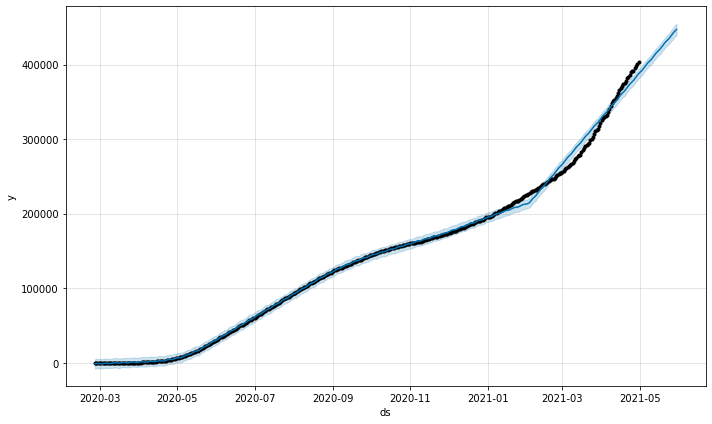

In [173]:
# plotando o gráfico de previsão
modelo.plot(previsao)

data_previsao =previsao[['ds', 'yhat']]
df_previsao = data_previsao.merge(teste_prophet, how='inner', on='ds')

In [174]:
# Olhando para o erro MAPE
y_true = df_previsao['y']
y_pred = df_previsao['yhat']
mean_absolute_percentage_error(y_true, y_pred)

0.037968163045513266

In [175]:
# Recriando o modelo
modelo = Prophet()

# Ajustando o modelo aos dados
modelo.fit(prophet_teste_treino)

# Criando dataframe com os períodos futuros para as previsões, vamos fazer a previsão para os próximos 30 dias
futuro = modelo.make_future_dataframe(periods= 30, freq = '1d')

# Realizando as previsões
previsao= modelo.predict(futuro)

# Agora podemos ver a nossa previsão
previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/_8zrxx83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6sty67d3/d1clkyu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43996', 'data', 'file=/tmp/tmp6sty67d3/_8zrxx83.json', 'init=/tmp/tmp6sty67d3/d1clkyu_.json', 'output', 'file=/tmp/tmp6sty67d3/prophet_modeljygosaoe/prophet_model-20221024142129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:21:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-26,-468.401638,-3308.090743,2336.049824,-468.401638,-468.401638,-24.699618,-24.699618,-24.699618,-24.699618,-24.699618,-24.699618,0.0,0.0,0.0,-493.101256
1,2020-02-27,-441.402422,-3033.622517,2476.865759,-441.402422,-441.402422,197.801521,197.801521,197.801521,197.801521,197.801521,197.801521,0.0,0.0,0.0,-243.600900
2,2020-02-28,-414.403206,-2881.823630,2780.005905,-414.403206,-414.403206,328.071179,328.071179,328.071179,328.071179,328.071179,328.071179,0.0,0.0,0.0,-86.332027
3,2020-02-29,-387.403990,-2977.070309,2785.888125,-387.403990,-387.403990,313.356898,313.356898,313.356898,313.356898,313.356898,313.356898,0.0,0.0,0.0,-74.047092
4,2020-03-01,-360.404774,-3100.646344,2678.118726,-360.404774,-360.404774,-40.917841,-40.917841,-40.917841,-40.917841,-40.917841,-40.917841,0.0,0.0,0.0,-401.322615


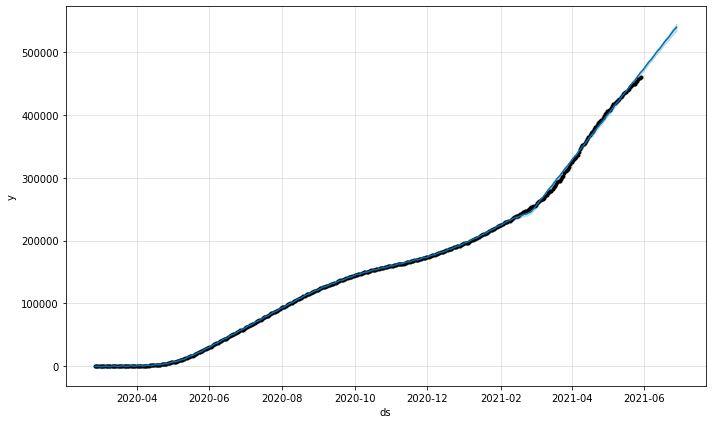

In [176]:
# plotando o gráfico de previsão
modelo.plot(previsao)

data_previsao =previsao[['ds', 'yhat']]
df_previsao = data_previsao.merge(teste_prophet, how='inner', on='ds')

In [177]:
data_previsao.tail(31)

,ds,yhat
458,2021-05-29,467885.767989
459,2021-05-30,469944.447201
460,2021-05-31,471890.342335
461,2021-06-01,474545.637461
462,2021-06-02,477199.527276
463,2021-06-03,479834.982366
464,2021-06-04,482378.205974
465,2021-06-05,484776.445644
466,2021-06-06,486835.124856
467,2021-06-07,488781.019990


Foi possível observar que de maneira geral a previsão de casos de covid, foi mais fácil de prever do que a previsão de mortes 